# Modeling Galaxy Formation and Evolution by using Machine Learning

In this notebook, we apply a bunch of ML techniques to try and model galaxy formation/evolution using ML. This notebook essentially reproduces all the results obtained in *insert link to arxiv/mnras*. 

Abstract copy-pasta'd from the paper:

We present a new exploratory framework to model galaxy formation and evolution in a hierarchical universe by using machine learning (ML). Our motivations are two-fold: (1) presenting a new, promising technique to study galaxy formation, and (2) quantitatively analyzing the extent of the influence of dark matter halo properties on small-scale structure in the backdrop of semi-analytical models (SAMs). We use the influential Millennium Simulation and the corresponding Munich SAM to train and test various sophisticated machine learning algorithms (k-Nearest Neighbors, decision trees, random forests and extremely randomized trees). By using only essential dark matter halo physical properties and a partial merger tree, our model predicts the hot gas mass, cold gas mass, bulge mass, total stellar mass, black hole mass and cooling radius ($M_{hot,gas}$, $M_{cold,gas}$, $M_{\star,bulge}$, $M_{\star, total}$, $M_{BH}$, $r_{cool}$) at $z=0$ for each central galaxy in a dark matter halo for the Millennium run. We obtain promising results for the hot gas mass, stellar mass in the bulge, and the total stellar mass with regression scores ($R^2$) of 0.99, 0.77, 0.78 and 0.86 respectively; the distributions for each, the BH mass-bulge mass relation, and the stellar mass-halo mass relation are also reproduced well. Our cold gas mass prediction using solely DM inputs is less robust ($R^2 = 0.39$) with severe underpredictions, confirming previous results by finding no  definitive mapping between cold gas mass and internal halo properties. We present the prediction of the cooling radius and obtain surprisingly good results; the distribution is reproduced and $R^2 = 0.87$. We show that our cold gas mass prediction isn't robust because ML is not able to pick up on the time evolution of the mass cooling ODE prescribed in the SAM by itself. We demonstrate this by including the cooling radius and hot gas mass over two snapshots in our inputs for the ML algorithms and repeat our analysis, which produces significantly better predictions, with the distribution of the cold gas mass being reproduced well with an $R^2$ of 0.82. Our results provide a unique and powerful phenomenological framework to explore the galaxy-halo connection that is built upon SAMs and demonstrably place ML as a promising and a significantly more computationally efficient tool to study small-scale structure formation.



In [33]:
import numpy as np
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score
from scipy.stats import kendalltau, spearmanr, pearsonr
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from operator import itemgetter
from sklearn import decomposition
import pandas as pd
import seaborn as sns
import time
import math
from IPython.display import Latex
%matplotlib inline

sns.set_style("white")
sns.set_style("ticks")

Make the size of the output cells bigger so that all the figures fit. 

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

Run helper.ipynb. The other notebook has all the helper functions that are used in this notebook for plots and other stuff.

In [22]:
%run 'helper.ipynb'

Ugly wget query to extract the relevant data from Millennium (i.e. track the main branch of each subhalo and extract internal halo properties). This won't run since a username and a password haven't been supplied; one can request a username/password from http://www.mpa-garching.mpg.de/millennium/. The resulting data file is in the github repository ('data.csv'). The data extraction is thoroughly described in the paper. The data files in the repository are split into 7 files because of the github file size limit. 

In [ ]:
!wget --http-user=<username> --http-passwd=<password> -O data.csv "http://gavo.mpa-garching.mpg.de/MyMillennium?action=doQuery&SQL=SELECT a.np, a.vMax, a.halfmassRadius, a.vDisp, a.spinX, a.spinY,blah.r_mean200,blah.r_crit200, blah.m_Crit200,a.spinZ,g.rvir,g.centralMvir,g.vvir,g1.rvir,g1.centralMvir,g1.vvir,a.m_mean200,a.m_crit200,a.m_tophat,a.peakMassMcrit200,a.peakMassVmax,b.np,b.vMax,b.vDisp,b.m_crit200,b.spinZ,b.lastCentralVmax,b.m_tophat,c.np,c.vMax,c.vDisp,c.m_tophat,c.m_crit200,c.spinZ,c.lastCentralVmax,d.np,d.vMax,d.vDisp,d.m_tophat,d.m_crit200,d.spinZ,d.lastCentralVmax,e.np,e.vMax,e.vDisp,e.m_crit200,e.spinZ,f.np,f.vMax,f.vDisp,f.m_crit200,f.spinZ,h.np,h.vMax,h.vDisp,h.m_crit200,h.spinZ,i.np,i.vMax,i.vDisp,i.m_crit200,i.spinZ,j.np,j.vMax,j.vDisp,j.m_crit200,j.spinZ,k.np,k.vMax,k.vDisp,k.m_crit200,k.spinZ,l.np,l.vMax,l.vDisp,l.m_crit200,l.spinZ,m.np,m.vMax,m.vDisp,m.m_crit200,m.spinZ,n.np,n.vMax,n.vDisp,n.m_crit200,n.spinZ,o.np,o.vMax,o.vDisp,o.m_crit200,o.spinZ,p.np,p.vMax,p.vDisp,p.m_crit200,p.spinZ,q.np,q.vMax,q.vDisp,q.m_crit200,q.spinZ,r.np,r.vMax,r.vDisp,r.m_crit200,s.np,s.vMax,s.vDisp,s.m_crit200,t.np,t.vMax,t.vDisp,t.m_crit200,u.np,u.vMax,u.vDisp,u.m_crit200,v.np,v.vMax,v.vDisp,v.m_crit200,w.np,w.vMax,w.vDisp,w.m_crit200,x.np,x.vMax,x.vDisp,x.m_crit200,y.vMax,y.vDisp,y.m_crit200,z.vMax,z.vDisp,z.m_crit200,ab.vMax,ab.vDisp,ab.m_crit200,bc.vMax,bc.vDisp,bc.m_crit200,cd.vMax,cd.vDisp,cd.m_crit200,de.vMax,de.vDisp,de.m_crit200,ef.vMax,ef.vDisp,ef.m_crit200,fg.vMax,fg.vDisp,fg.m_crit200,gh.vMax,gh.vDisp,gh.m_crit200,hi.vMax,hi.vDisp,hi.m_crit200,ij.vMax,ij.vDisp,ij.m_crit200,jk.vMax,jk.vDisp,jk.m_crit200,kl.vMax,kl.vDisp,kl.m_crit200,lm.vMax,lm.vDisp,lm.m_crit200,mn.vMax,mn.vDisp,mn.m_crit200,no.vMax,no.vDisp,no.m_crit200,op.vMax,op.vDisp,op.m_crit200,pq.vMax,pq.vDisp,pq.m_crit200,qr.vMax,qr.vDisp,qr.m_crit200,rs.vMax,rs.vDisp,rs.m_crit200,st.vMax,st.vDisp,st.m_crit200,g1.coolingradius,g1.hotGas,g.stellarMass,g.coldGas,g.bulgeMass,g.hotGas,g.coolingRadius,g.blackHoleMass FROM MPAHaloTrees..MR as a INNER JOIN MField..FofSubHalo as mfs ON mfs.subhaloId = a.subhaloFileId INNER JOIN MField..FOF as blah ON blah.fofId = mfs.fofId INNER JOIN Guo2010a..MR as g on g.haloID = a.haloId INNER JOIN MPAHaloTrees..MR as b on b.haloId = a.firstProgenitorId INNER JOIN Guo2010a..MR as g1 on g1.haloID = b.haloId INNER JOIN MPAHaloTrees..MR as c on c.haloId = b.firstProgenitorId INNER JOIN MPAHaloTrees..MR as d on d.haloId = c.firstProgenitorId INNER JOIN MPAHaloTrees..MR as e on e.haloId = d.firstProgenitorId INNER JOIN MPAHaloTrees..MR as f on f.haloId = e.firstProgenitorId INNER JOIN MPAHaloTrees..MR as h on h.haloId = f.firstProgenitorId INNER JOIN MPAHaloTrees..MR as i on i.haloId = h.firstProgenitorId INNER JOIN MPAHaloTrees..MR as j on j.haloId = i.firstProgenitorId INNER JOIN MPAHaloTrees..MR as k on k.haloId = j.firstProgenitorId INNER JOIN MPAHaloTrees..MR as l on l.haloId = k.firstProgenitorId INNER JOIN MPAHaloTrees..MR as m on m.haloId = l.firstProgenitorId INNER JOIN MPAHaloTrees..MR as n on n.haloId = m.firstProgenitorId INNER JOIN MPAHaloTrees..MR as o on o.haloId = n.firstProgenitorId INNER JOIN MPAHaloTrees..MR as p on p.haloId = o.firstProgenitorId INNER JOIN MPAHaloTrees..MR as q on q.haloId = p.firstProgenitorId INNER JOIN MPAHaloTrees..MR as r on r.haloId = q.firstProgenitorId INNER JOIN MPAHaloTrees..MR as s on s.haloId = r.firstProgenitorId INNER JOIN MPAHaloTrees..MR as t on t.haloId = s.firstProgenitorId INNER JOIN MPAHaloTrees..MR as u on u.haloId = t.firstProgenitorId INNER JOIN MPAHaloTrees..MR as v on v.haloId = u.firstProgenitorId INNER JOIN MPAHaloTrees..MR as w on w.haloId = v.firstProgenitorId INNER JOIN MPAHaloTrees..MR as x on x.haloId = w.firstProgenitorId INNER JOIN MPAHaloTrees..MR as y on y.haloId = x.firstProgenitorId INNER JOIN MPAHaloTrees..MR as z on z.haloId = y.firstProgenitorId INNER JOIN MPAHaloTrees..MR as ab on ab.haloId = z.firstProgenitorId INNER JOIN MPAHaloTrees..MR as bc on bc.haloId = ab.firstProgenitorId INNER JOIN MPAHaloTrees..MR as cd on cd.haloId = bc.firstProgenitorId INNER JOIN MPAHaloTrees..MR as de on de.haloId = cd.firstProgenitorId INNER JOIN MPAHaloTrees..MR as ef on ef.haloId = de.firstProgenitorId INNER JOIN MPAHaloTrees..MR as fg on fg.haloId = ef.firstProgenitorId INNER JOIN MPAHaloTrees..MR as gh on gh.haloId = fg.firstProgenitorId INNER JOIN MPAHaloTrees..MR as hi on hi.haloId = gh.firstProgenitorId INNER JOIN MPAHaloTrees..MR as ij on ij.haloId = hi.firstProgenitorId INNER JOIN MPAHaloTrees..MR as jk on jk.haloId = ij.firstProgenitorId INNER JOIN MPAHaloTrees..MR as kl on kl.haloId = jk.firstProgenitorId INNER JOIN MPAHaloTrees..MR as lm on lm.haloId = kl.firstProgenitorId INNER JOIN MPAHaloTrees..MR as mn on mn.haloId = lm.firstProgenitorId INNER JOIN MPAHaloTrees..MR as no on no.haloId = mn.firstProgenitorId INNER JOIN MPAHaloTrees..MR as op on op.haloId = no.firstProgenitorId INNER JOIN MPAHaloTrees..MR as pq on pq.haloId = op.firstProgenitorId INNER JOIN MPAHaloTrees..MR as qr on qr.haloId = pq.firstProgenitorId INNER JOIN MPAHaloTrees..MR as rs on rs.haloId = qr.firstProgenitorId INNER JOIN MPAHaloTrees..MR as st on st.haloId = rs.firstProgenitorId WHERE (a.np > 1162.67) AND (g.type=0) AND (a.snapnum=63) AND (g1.type=0)"

First, we read in the data. We look at how many haloes there are. We then cut out all the (VERY) extreme outliers (anything greater than the mean by 30 standard deviations). Calculate the base MSE for each mass component and the cooling radius. The base MSE is defined as: $MSE_b = \frac{1}{N_{test}}\sum_{i=1}^{i=N_{test}-1} \left(X_{test}^{i} - X_{mean,train}\right)^2$. Let's also make a violinplot for the different mass components to see what the distributions look like. 

(365456, 201)
(365408, 201)
Base MSE for stellar mass is: 24.787996, cold gas mass is: 0.526936, stellar mass in the bulge is: 28.165416, hot gas mass is: 64524.910355, cooling radius is: 0.000439 and black hole mass is: 0.000468


//anaconda/lib/python2.7/site-packages/pandas/core/frame.py:1819: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


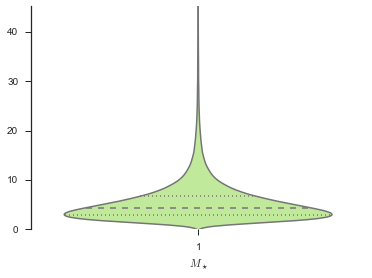

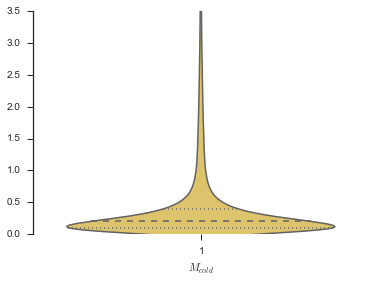

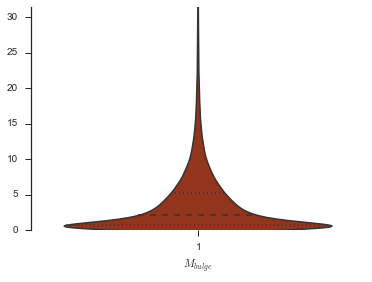

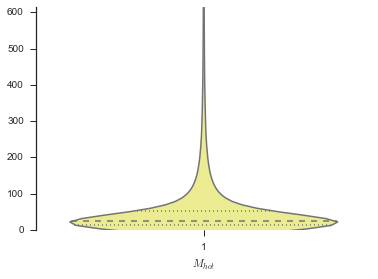

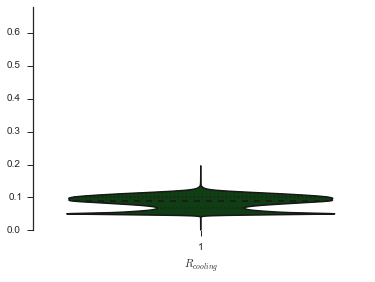

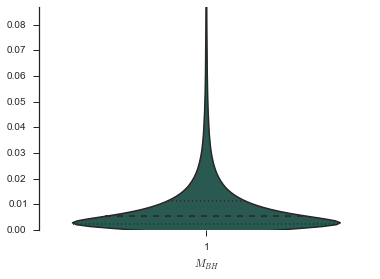

In [4]:
df = pd.read_csv('/Users/harshilkamdar/Desktop/paper/data.csv') #load in the data
print(df.shape) 

Q = df.values
M = Q[:,195:201] #mass; need to do this in an iffy way (i.e. not using pandas) because there are duplicate labels

means = np.mean(M, axis=0) 
stds = np.std(M, axis=0)
cutoffs = means + 30*stds #cutoffs to remove extreme outliers; 30 seems reasonable

df = df[df.stellarMass < cutoffs[0]][df.coldGas < cutoffs[1]][df.bulgeMass < cutoffs[2]][df.hotGas < cutoffs[3]][df.blackHoleMass < cutoffs[5]] #god bless pandas
print df.shape #just to see how many entries we lost; it turns out to be only 48 out of 350k+ 

Q = df.values #same here; this is really not recommended since
H = Q[:,0:193] #halo inputs; no baryonic quantities are included here
M = Q[:,195:201] #galaxy masses

training_size = 0.35 

H_train, H_test, M_train, M_test = cross_validation.train_test_split(H, M, train_size=training_size, random_state=23) #the random state is chosen for consistency across different runs

HB = np.c_[H, Q[:,193:195], M[:,3], M[:,4]] #halo inputs with cooling radius and hot gas from the last two snapshots
C = np.c_[M[:,1]] #just the cold gas mass

N_train, N_test, C_train, C_test = cross_validation.train_test_split(HB, C, train_size=training_size, random_state=23)

base_mse_st = mse(M_test[:,0], np.mean(M_train[:,0])) 
base_mse_co = mse(M_test[:,1], np.mean(M_train[:,1])) 
base_mse_bu = mse(M_test[:,2], np.mean(M_train[:,2]))
base_mse_ho = mse(M_test[:,3], np.mean(M_train[:,3]))
base_mse_rc = mse(M_test[:,4], np.mean(M_train[:,4]))
base_mse_bh = mse(M_test[:,5], np.mean(M_train[:,5]))

base_mse = np.c_[base_mse_st, base_mse_co, base_mse_bu, base_mse_ho, base_mse_rc, base_mse_bh] 

print('Base MSE for stellar mass is: %f, cold gas mass is: %f, stellar mass in the bulge is: %f, hot gas mass is: %f, cooling radius is: %f and black hole mass is: %f' % (base_mse_st, base_mse_co, base_mse_bu, base_mse_ho, base_mse_rc, base_mse_bh))

titles = ['$M_{\star}$', '$M_{cold}$', '$M_{bulge}$', '$M_{hot}$', '$R_{cooling}$', '$M_{BH}$']

#let's see what the distributions look like. seaborn is A+
[plot_distribution(M[:,i], titles[i], np.random.choice(sns.xkcd_rgb.values())) for i in xrange(0,6)] #TODO: make prettier. also, xkcd colors~ 

del df
del H, M, HB, C #delete everything from memory because we weren't exactly memory conscious. oops

Let's make a colormap for future plots.

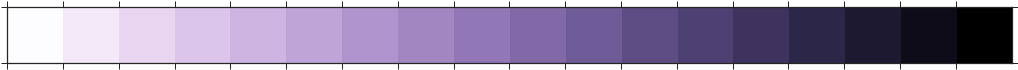

In [6]:
sns.palplot(sns.cubehelix_palette(18, start=3, rot=0.1, dark=0, light=0.99))
cold_cmap = sns.cubehelix_palette(18, start=3, rot=0.1, dark=0, light=0.99, as_cmap=True)

Let's do the whole machine learning thing everyone keeps talking about. The idea here is to use a variety of supervised techniques to predict the accumulated baryonic mass components at $z=0$ using solely dark matter halo properties (discussed more in the paper) and a partial merger history. Machine learning is great because it enables two things: (1) it provides a purely phenomenological framework that is relatively simple and computationally cheap (compared to other galaxy formation models and (2) it serves as a unique and useful analysis tool by letting us quantitatively analyze the extent of the influence of dark matter halo properties on small-scale structure in the backdrop of semi-analytical models (SAMs). Onwards and forwards! We'll use 4 techniques: kNN, decision trees, random forests and extra trees. We use scikit-learn to do our analysis. The base MSE, reduced MSE, the factor reduction (base MSE/reduced MSE), pearson correlation and R^2 are computed and shown to provide a quantitative metric for the robustness of our predictions. A hexbin plot with a KDE distribution is plotted for each mass component and the cooling radius for each technique. A violinplot, which essentially lets us zoom in to the interesting bits and show a distribution via a KDE, is also plotted for each technique. We redo our analysis including the cooling radius and the hot gas mass over the last two snapshots to get a more robust prediction of the cold gas mass using random forests and extra trees. We also plot the stellar mass-halo mass relation, the black hole mass-bulge mass relation and the cold gas mass fraction vs stellar mass for the simulated ML galaxies and Guo (2011) galaxies to show the physical reasonability of our results. 

Okay, let's try out the first technique: kNN (http://en.wikipedia.org/wiki/K-nearest_neighbor_algorithm). 

MSE using kNN for predicting the stellar mass is 6.769575, cold gas mass is 0.400616, bulge mass is 7.144989, hot gas mass is 1324.217570, cooling radius is 0.000081 and black hole mass is 0.000067

Factor reduction (MSE_b/MSE) for kNN for predicting the stellar mass is 3.661677, cold gas mass is 1.315315, bulge mass is 3.941982, hot gas mass is 48.726819, cooling radius is 5.410877 and black hole mass is 6.970379

R^2 score for kNN for predicting the stellar mass is 0.726895, cold gas mass is 0.239718, bulge mass is 0.746315, hot gas mass is 0.979477, cooling radius is 0.815187 and black hole mass is 0.856535

Pearson correlation for kNN for predicting the stellar mass is 0.853520, cold gas mass is 0.490456, bulge mass is 0.865114, hot gas mass is 0.991041, cooling radius is 0.903169 and black hole mass is 0.926284


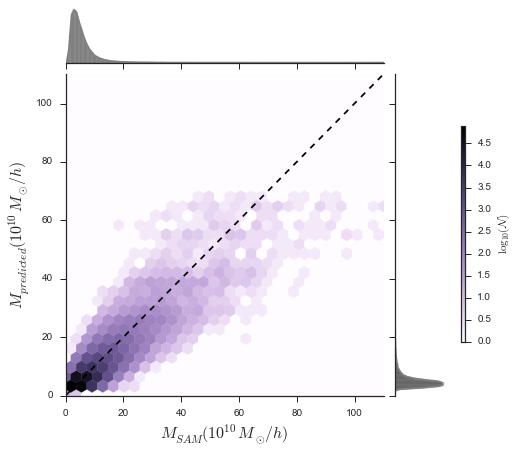

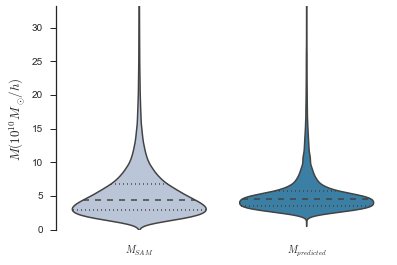

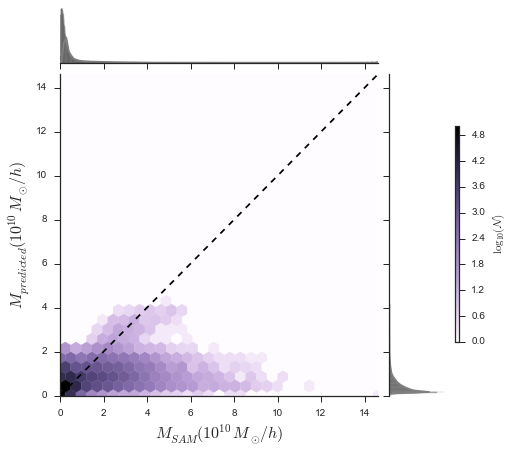

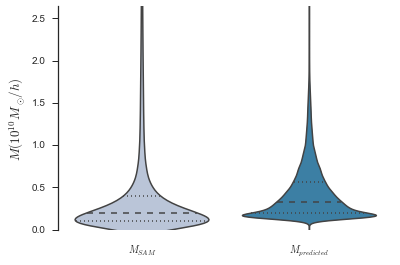

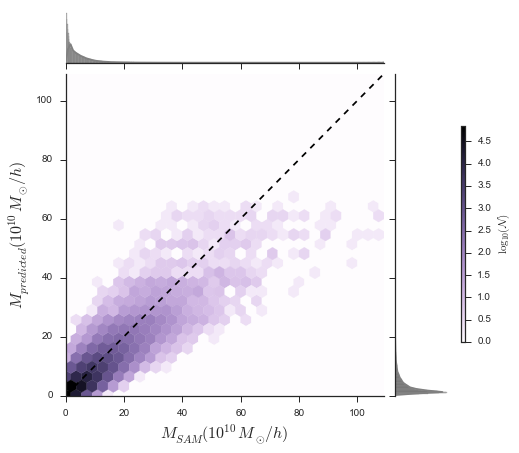

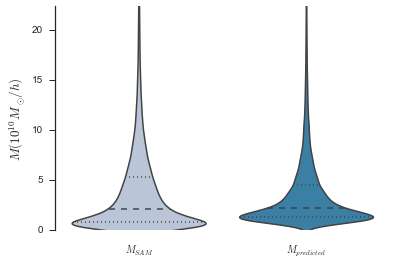

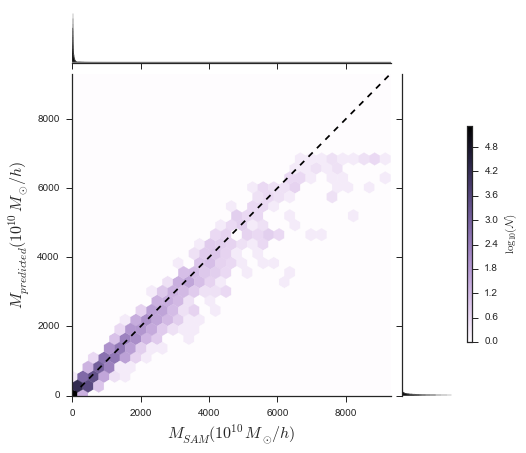

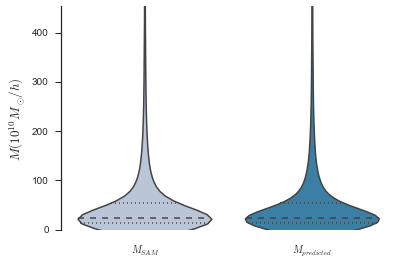

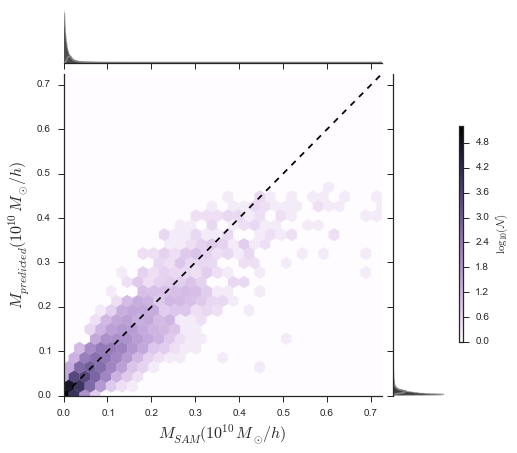

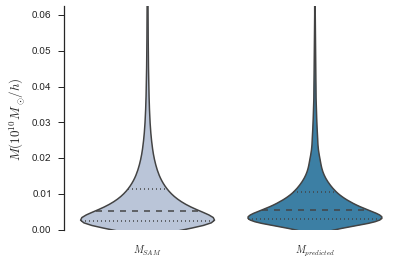

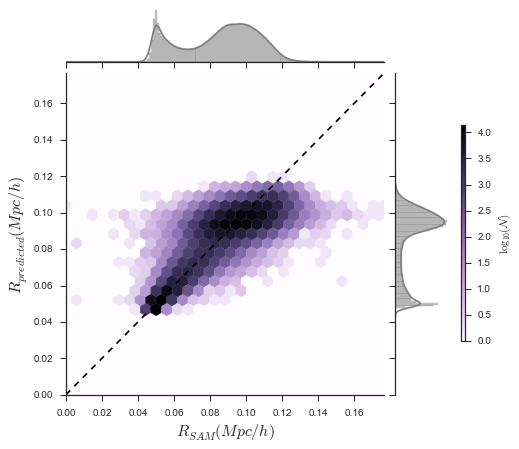

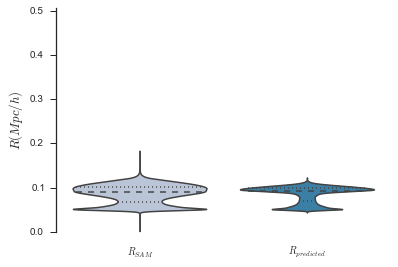

In [32]:
'''
param_dist = {<some parameter space to search over>}
knn = KNeighborsRegressor()
grid_search = GridSearchCV(knn, param_grid=param_dist)
grid_search.fit(B_train, M_train)
report(grid_search.grid_scores_)

Commented out because a full grid search will take too long with such a big multidimensional data set. The report function (in helper.ipynb) will print the 3 best parameter combinations. Included here for completeness. 
'''

knn = KNeighborsRegressor(60, weights='distance') #knn is cool, i guess
M_pred_knn = knn.fit(H_train, M_train).predict(H_test)
mse_knn = mse(M_test, M_pred_knn)
del knn 

print('MSE using kNN for predicting the stellar mass is %f, cold gas mass is %f, bulge mass is %f, hot gas mass is %f, cooling radius is %f and black hole mass is %f\n' % (mse_knn[0], mse_knn[1],  mse_knn[2], mse_knn[3], mse_knn[4], mse_knn[5]))

base_mse = np.ravel(base_mse)

factors = base_mse/mse_knn

print('Factor reduction (MSE_b/MSE) for kNN for predicting the stellar mass is %f, cold gas mass is %f, bulge mass is %f, hot gas mass is %f, cooling radius is %f and black hole mass is %f\n' % (factors[0], factors[1],  factors[2], factors[3], factors[4], factors[5])) #TODO: prettier way to print this stuff
print('R^2 score for kNN for predicting the stellar mass is %f, cold gas mass is %f, bulge mass is %f, hot gas mass is %f, cooling radius is %f and black hole mass is %f\n' % (r2_score(M_test[:,0], M_pred_knn[:,0]), r2_score(M_test[:,1], M_pred_knn[:,1]),  r2_score(M_test[:,2], M_pred_knn[:,2]), r2_score(M_test[:,3], M_pred_knn[:,3]), r2_score(M_test[:,4], M_pred_knn[:,4]), r2_score(M_test[:,5], M_pred_knn[:,5])))
print('Pearson correlation for kNN for predicting the stellar mass is %f, cold gas mass is %f, bulge mass is %f, hot gas mass is %f, cooling radius is %f and black hole mass is %f' % (pearsonr(M_test[:,0], M_pred_knn[:,0])[0], pearsonr(M_test[:,1], M_pred_knn[:,1])[0],  pearsonr(M_test[:,2], M_pred_knn[:,2])[0], pearsonr(M_test[:,3], M_pred_knn[:,3])[0], pearsonr(M_test[:,4], M_pred_knn[:,4])[0], pearsonr(M_test[:,5], M_pred_knn[:,5])[0]))

[genplots_M(np.c_[M_test[:,i], M_pred_knn[:,i]], mse_knn[i]) for i in [x for x in xrange(0,6) if x != 4]]
genplots_M(np.c_[M_test[:,4], M_pred_knn[:,4]], mse_knn[4], plot_type='R') 

Next, we try decision trees. A good reference: L. Breiman, J. Friedman, R. Olshen, and C. Stone, “Classification and Regression Trees”, Wadsworth, Belmont, CA, 1984. Performs the worst. Fast though.

MSE using Decision Trees for predicting the stellar mass is 7.777352, cold gas mass is 0.452274, bulge mass is 8.198451, hot gas mass is 136.810639, cooling radius is 0.000090 and black hole mass is 0.000087

Factor reduction (MSE_b/MSE) using Decision Trees for predicting the stellar mass is 3.187202, cold gas mass is 1.165080, bulge mass is 3.435456, hot gas mass is 471.636642, cooling radius is 4.899914 and black hole mass is 5.360105

R^2 score using Decision Trees for predicting the stellar mass is 0.686238, cold gas mass is 0.141681, bulge mass is 0.708912, hot gas mass is 0.997880, cooling radius is 0.795914 and black hole mass is 0.813435

Pearson correlation using Decision Trees for predicting the stellar mass is 0.828458, cold gas mass is 0.376419, bulge mass is 0.842033, hot gas mass is 0.998944, cooling radius is 0.892143 and black hole mass is 0.902046


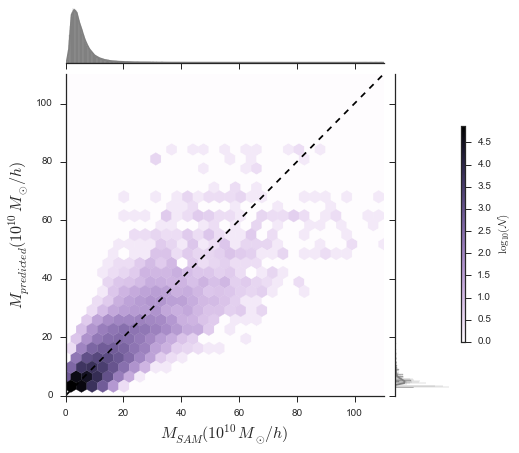

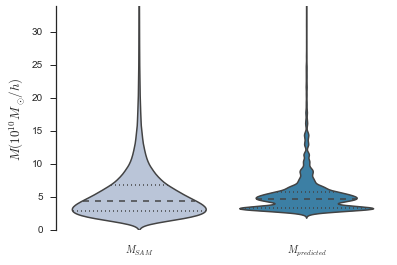

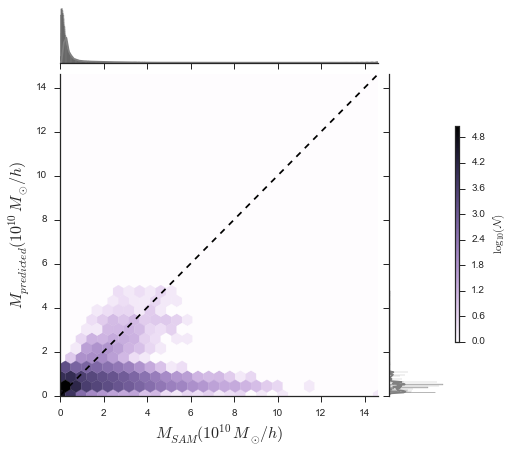

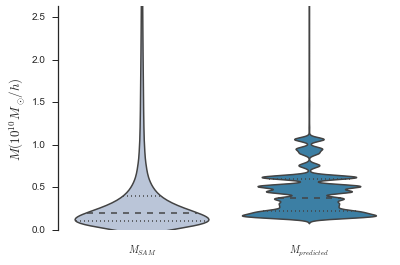

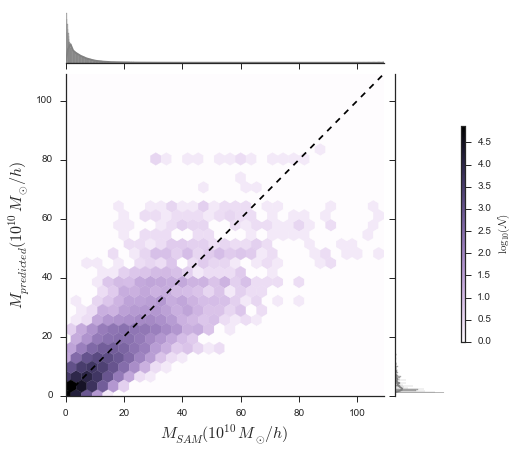

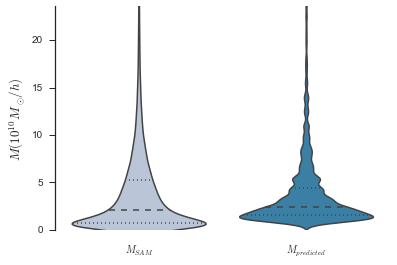

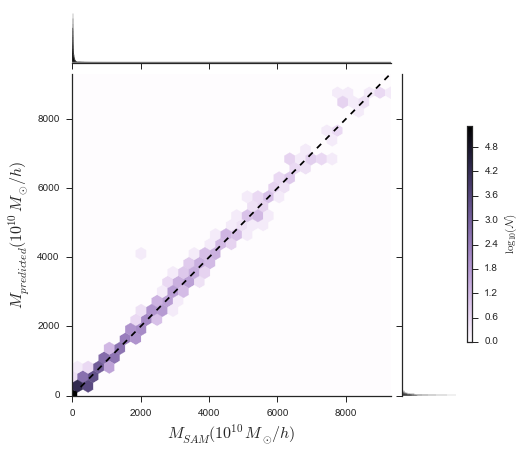

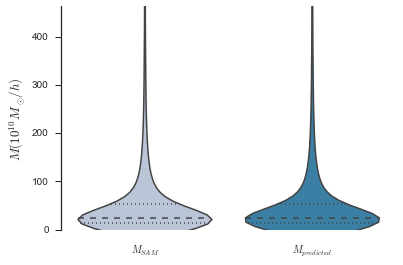

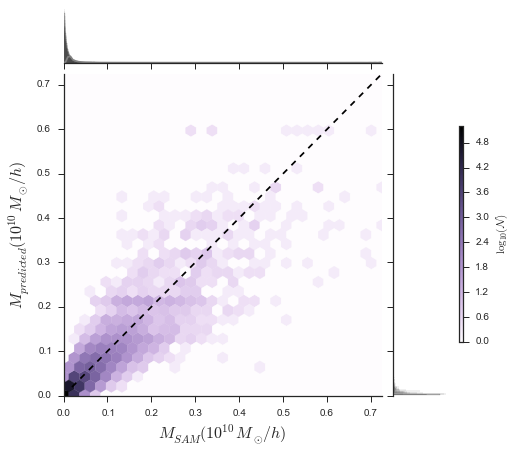

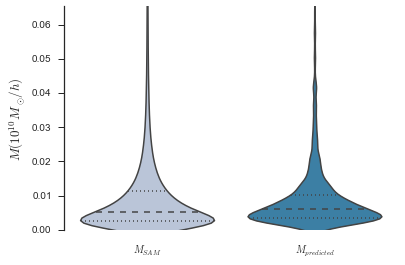

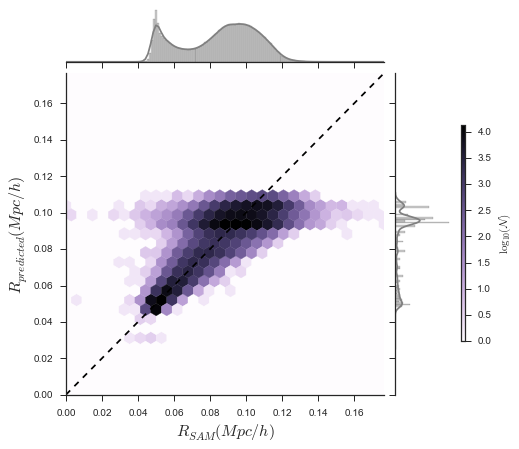

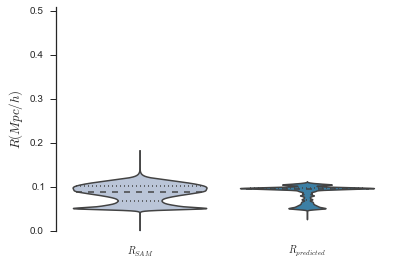

In [31]:
'''
param_dist = {<some parameter space to search over>}
dtree_r = DecisionTreeRegressor(random_state=0)
grid_search = GridSearchCV(dtree_r, param_grid=param_dist)
grid_search.fit(B_train, M_train)
report(grid_search.grid_scores_)

Commented out because a full grid search will take too long with such a big multidimensional data set. The report function (in helper.ipynb) will print the 3 best parameter combinations. Included here for completeness. 
'''
dtree_r = DecisionTreeRegressor(max_depth=8, min_samples_split=4, min_samples_leaf=3) #treez
M_pred_dtree = dtree_r.fit(H_train, M_train).predict(H_test)
mse_dtree = mse(M_test, M_pred_dtree)
del dtree_r

print('MSE using Decision Trees for predicting the stellar mass is %f, cold gas mass is %f, bulge mass is %f, hot gas mass is %f, cooling radius is %f and black hole mass is %f\n' % (mse_dtree[0], mse_dtree[1],  mse_dtree[2], mse_dtree[3], mse_dtree[4], mse_dtree[5]))

factors = base_mse/mse_dtree

print('Factor reduction (MSE_b/MSE) using Decision Trees for predicting the stellar mass is %f, cold gas mass is %f, bulge mass is %f, hot gas mass is %f, cooling radius is %f and black hole mass is %f\n' % (factors[0], factors[1],  factors[2], factors[3], factors[4], factors[5])) #TODO: prettier way to print this stuff
print('R^2 score using Decision Trees for predicting the stellar mass is %f, cold gas mass is %f, bulge mass is %f, hot gas mass is %f, cooling radius is %f and black hole mass is %f\n' % (r2_score(M_test[:,0], M_pred_dtree[:,0]), r2_score(M_test[:,1], M_pred_dtree[:,1]),  r2_score(M_test[:,2], M_pred_dtree[:,2]), r2_score(M_test[:,3], M_pred_dtree[:,3]), r2_score(M_test[:,4], M_pred_dtree[:,4]), r2_score(M_test[:,5], M_pred_dtree[:,5])))
print('Pearson correlation using Decision Trees for predicting the stellar mass is %f, cold gas mass is %f, bulge mass is %f, hot gas mass is %f, cooling radius is %f and black hole mass is %f' % (pearsonr(M_test[:,0], M_pred_dtree[:,0])[0], pearsonr(M_test[:,1], M_pred_dtree[:,1])[0],  pearsonr(M_test[:,2], M_pred_dtree[:,2])[0], pearsonr(M_test[:,3], M_pred_dtree[:,3])[0], pearsonr(M_test[:,4], M_pred_dtree[:,4])[0], pearsonr(M_test[:,5], M_pred_dtree[:,5])[0]))

[genplots_M(np.c_[M_test[:,i], M_pred_dtree[:,i]], mse_dtree[i]) for i in [x for x in xrange(0,6) if x != 4]]
genplots_M(np.c_[M_test[:,4], M_pred_dtree[:,4]], mse_dtree[4], plot_type='R') 

Random forests. A good reference: http://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm. 

MSE using Random Forests for predicting the stellar mass is 5.759800, cold gas mass is 0.319279, bulge mass is 6.300065, hot gas mass is 70.540622, cooling radius is 0.000060 and black hole mass is 0.000068

Factor reduction (MSE_b/MSE) for Random Forests for predicting the stellar mass is 4.303621, cold gas mass is 1.650390, bulge mass is 4.470654, hot gas mass is 914.719897, cooling radius is 7.346315 and black hole mass is 6.937852

R^2 score using Random Forests for predicting the stellar mass is 0.767632, cold gas mass is 0.394076, bulge mass is 0.776314, hot gas mass is 0.998907, cooling radius is 0.863877 and black hole mass is 0.855862

Pearson correlation using Random Forests for predicting the stellar mass is 0.876333, cold gas mass is 0.630118, bulge mass is 0.881211, hot gas mass is 0.999453, cooling radius is 0.929513 and black hole mass is 0.925294


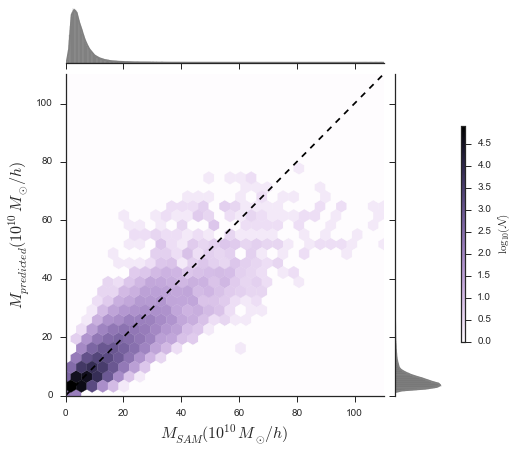

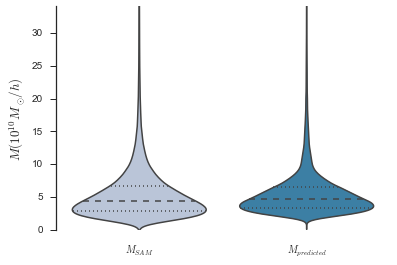

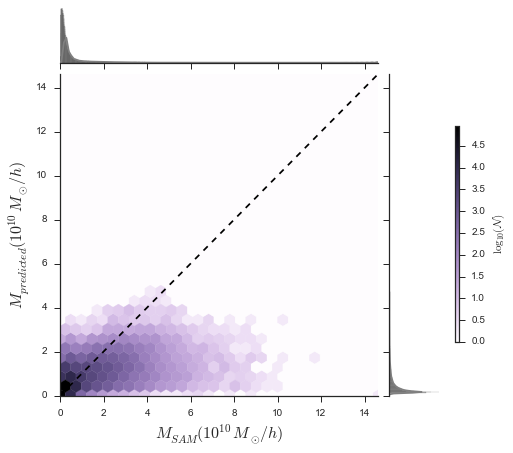

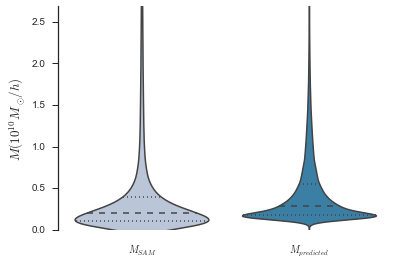

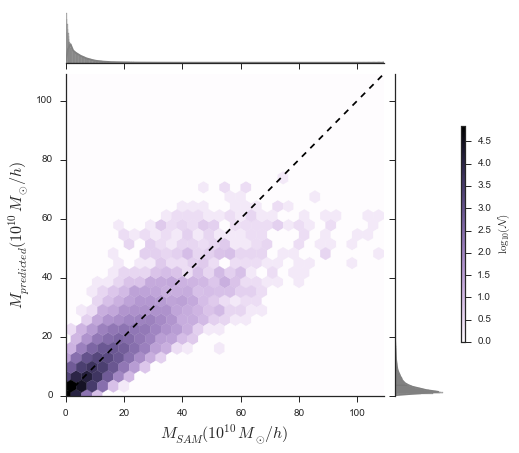

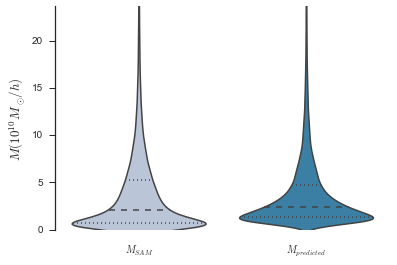

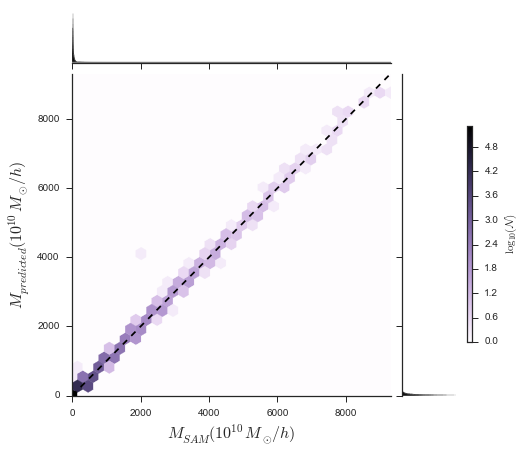

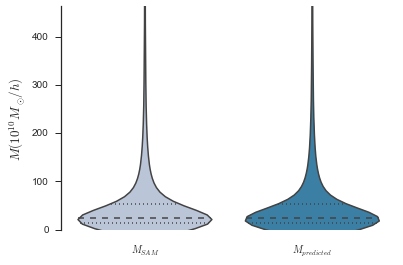

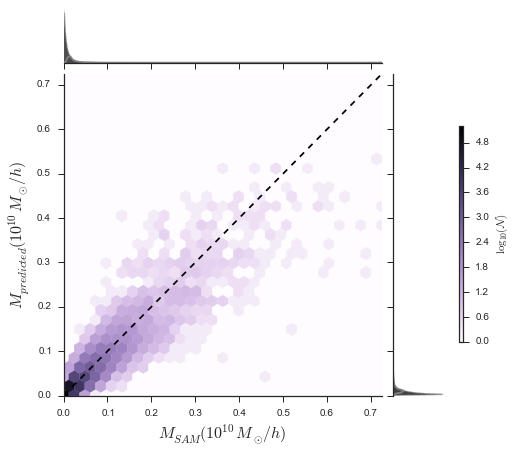

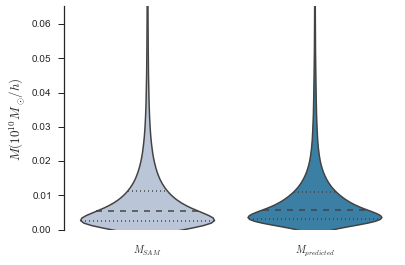

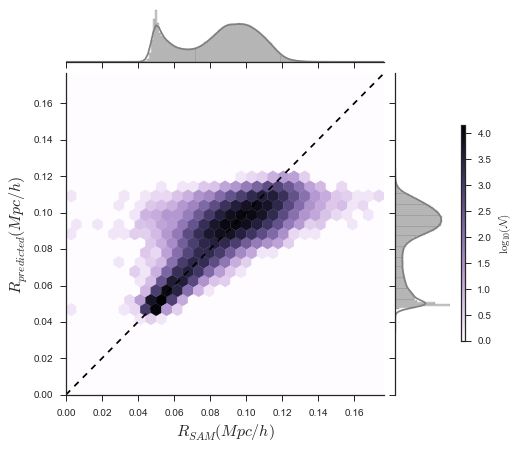

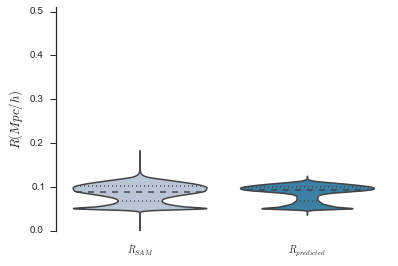

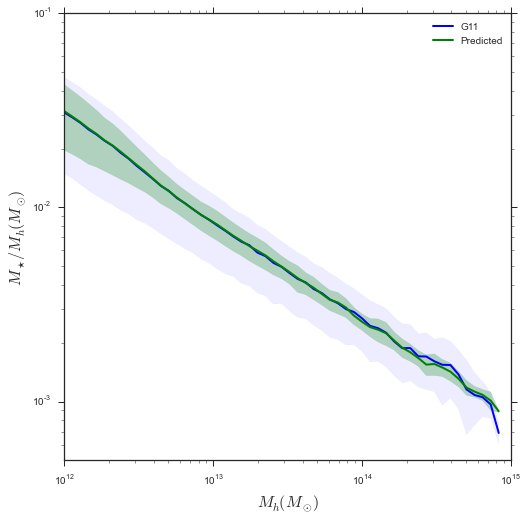

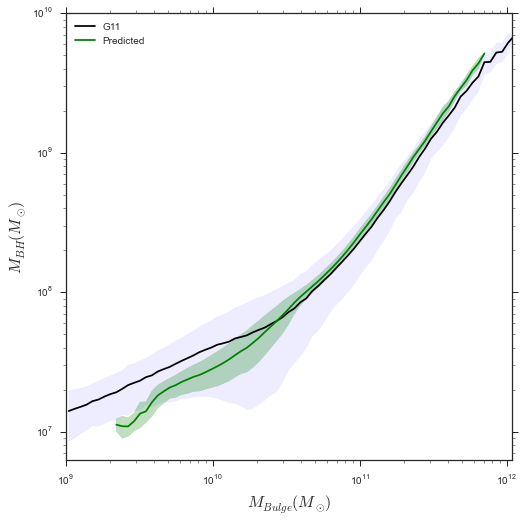

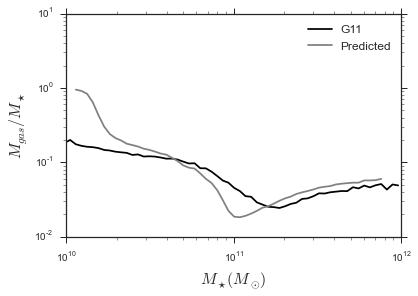

MSE using kNN for predicting the cold gas mass including the baryonic inputs is 0.097172
R^2 score using Random Forests for predicting the cold gas mass including the baryonic inputs is 0.815588
Pearson correlation using Random Forests for predicting the cold gas mass including the baryonic inputs is 0.904694


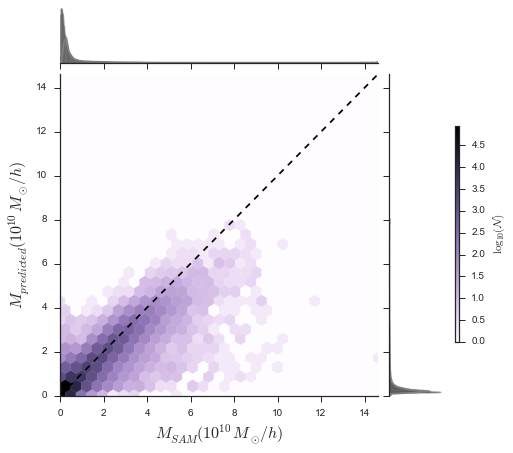

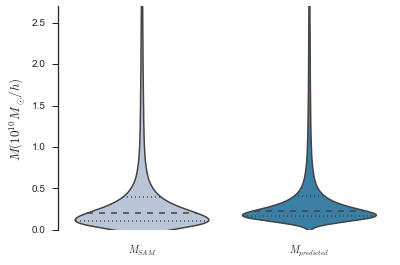

In [26]:
'''
param_dist = {<some paramter grid>}
rf = RandomForestRegressor(random_state=0)
grid_search = GridSearchCV(rf, param_grid=param_dist)
grid_search.fit(B_train, M_train)

report(grid_search.grid_scores_)

Commented out because a full grid search will take too long with such a big multidimensional data set. The report function (in helper.ipynb) will print the 3 best parameter combinations. Included here for completeness. 
'''
rf = RandomForestRegressor(n_estimators=300, n_jobs=-1, min_samples_split=5)
rf.fit(H_train, M_train)
M_pred_rf = rf.predict(H_test)

mse_rf = mse(M_test, M_pred_rf)
del rf

print('MSE using Random Forests for predicting the stellar mass is %f, cold gas mass is %f, bulge mass is %f, hot gas mass is %f, cooling radius is %f and black hole mass is %f\n' % (mse_rf[0], mse_rf[1], mse_rf[2], mse_rf[3], mse_rf[4], mse_rf[5]))

factors = base_mse/mse_rf

print('Factor reduction (MSE_b/MSE) for Random Forests for predicting the stellar mass is %f, cold gas mass is %f, bulge mass is %f, hot gas mass is %f, cooling radius is %f and black hole mass is %f\n' % (factors[0], factors[1],  factors[2], factors[3], factors[4], factors[5])) #TODO: prettier way to print this stuff
print('R^2 score using Random Forests for predicting the stellar mass is %f, cold gas mass is %f, bulge mass is %f, hot gas mass is %f, cooling radius is %f and black hole mass is %f\n' % (r2_score(M_test[:,0], M_pred_rf[:,0]), r2_score(M_test[:,1], M_pred_rf[:,1]),  r2_score(M_test[:,2], M_pred_rf[:,2]), r2_score(M_test[:,3], M_pred_rf[:,3]), r2_score(M_test[:,4], M_pred_rf[:,4]), r2_score(M_test[:,5], M_pred_rf[:,5])))
print('Pearson correlation using Random Forests for predicting the stellar mass is %f, cold gas mass is %f, bulge mass is %f, hot gas mass is %f, cooling radius is %f and black hole mass is %f' % (pearsonr(M_test[:,0], M_pred_rf[:,0])[0], pearsonr(M_test[:,1], M_pred_rf[:,1])[0],  pearsonr(M_test[:,2], M_pred_rf[:,2])[0], pearsonr(M_test[:,3], M_pred_rf[:,3])[0], pearsonr(M_test[:,4], M_pred_rf[:,4])[0], pearsonr(M_test[:,5], M_pred_rf[:,5])[0]))

[genplots_M(np.c_[M_test[:,i], M_pred_rf[:,i]], mse_rf[i]) for i in [x for x in xrange(0,6) if x != 4]]
genplots_M(np.c_[M_test[:,4], M_pred_rf[:,4]], mse_rf[4], plot_type='R') 

plot_smhm(M_test[:,0], M_pred_rf[:,0], H_test[:,0])
plot_bhbulge(M_test[:,5], M_pred_rf[:,5], M_test[:,2], M_pred_rf[:,2])
plot_coldgasfrac(M_test[:,1], M_pred_rf[:,1], M_test[:,0], M_pred_rf[:,0])

C_train = np.ravel(C_train)
C_test = np.ravel(C_test)

rf = RandomForestRegressor(n_estimators=300, n_jobs=-1, min_samples_split=5)
rf.fit(N_train, C_train)
C_pred_rf = rf.predict(N_test)

mse_rf_mod = mse(C_test,C_pred_rf)

print('MSE using kNN for predicting the cold gas mass including the baryonic inputs is %f' % mse_rf_mod)
print('R^2 score using Random Forests for predicting the cold gas mass including the baryonic inputs is %f' %  r2_score(C_test[:], C_pred_rf[:]))
print('Pearson correlation using Random Forests for predicting the cold gas mass including the baryonic inputs is %f' % pearsonr(C_test[:], C_pred_rf[:])[0])

genplots_M(np.c_[C_test[:],C_pred_rf[:]], mse_rf_mod) 

Extra Trees Regression. Similar to random forests. Does the best. Fairly quick. A good reference: P. Geurts, D. Ernst., and L. Wehenkel, “Extremely randomized trees”, Machine Learning, 63(1), 3-42, 2006. 

MSE using Extra Trees for predicting the stellar mass is 5.758311, cold gas mass is 0.318115, bulge mass is 6.309959, hot gas mass is 58.739453, cooling radius is 0.000059 and black hole mass is 0.000066

Factor reduction (MSE_b/MSE) for Extra Trees for predicting the stellar mass is 4.304734, cold gas mass is 1.656432, bulge mass is 4.463645, hot gas mass is 1098.493545, cooling radius is 7.434255 and black hole mass is 7.080821

R^2 score using Extra Trees for predicting the stellar mass is 0.767692, cold gas mass is 0.396286, bulge mass is 0.775963, hot gas mass is 0.999090, cooling radius is 0.865487 and black hole mass is 0.858772

Pearson correlation using Extra Trees for predicting the stellar mass is 0.876314, cold gas mass is 0.632437, bulge mass is 0.880963, hot gas mass is 0.999546, cooling radius is 0.930403 and black hole mass is 0.926820


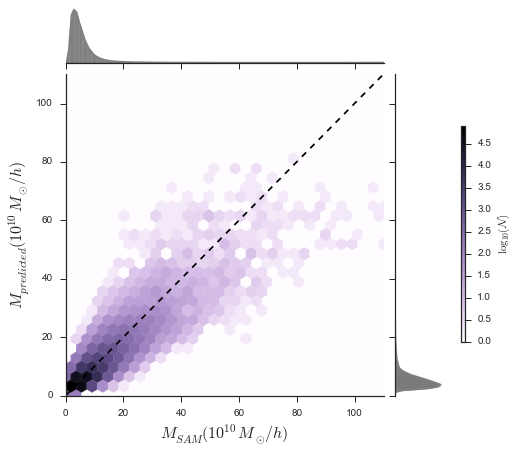

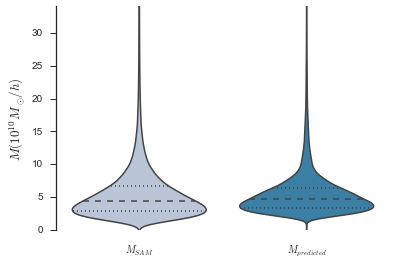

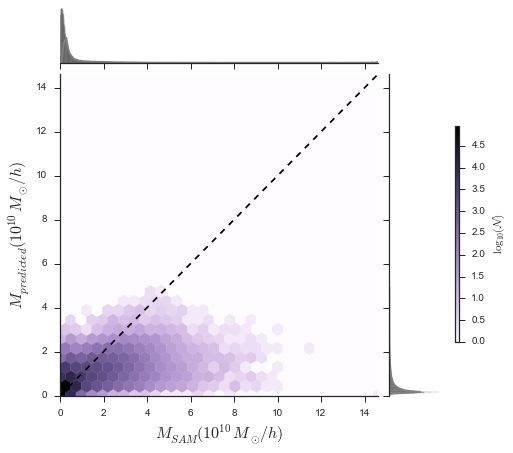

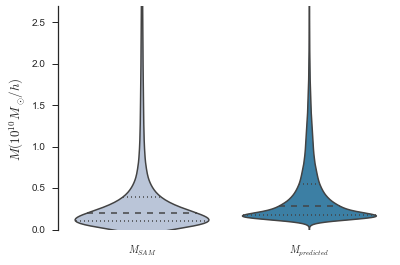

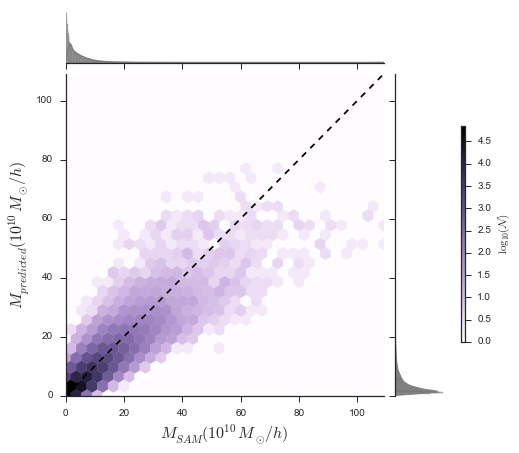

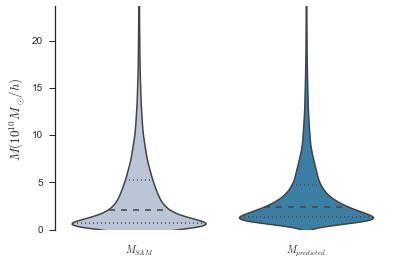

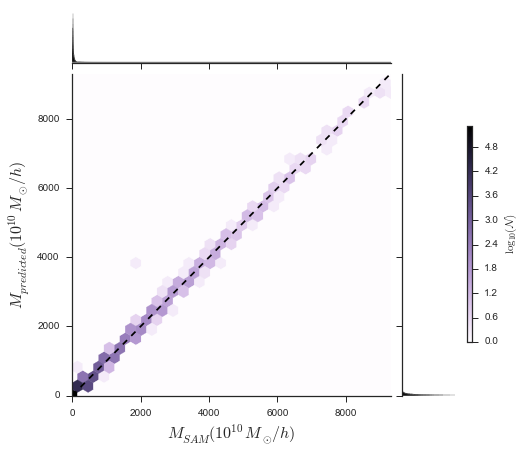

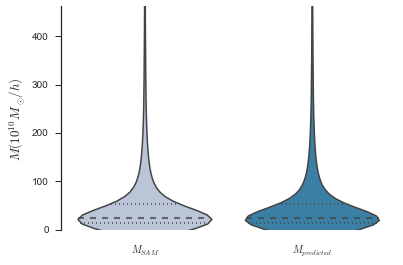

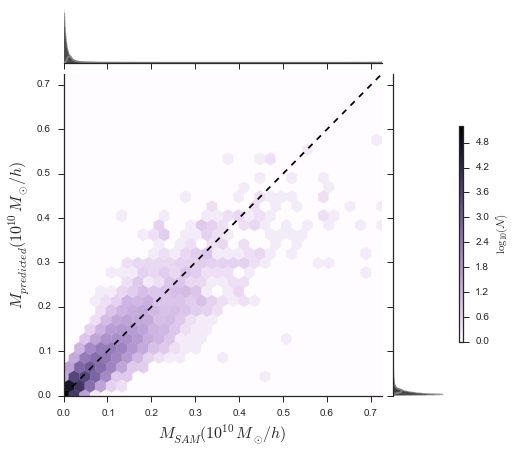

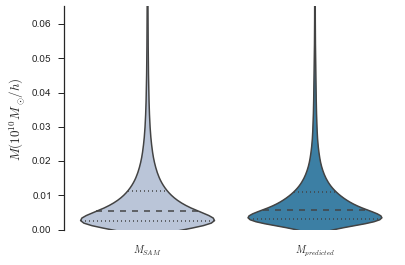

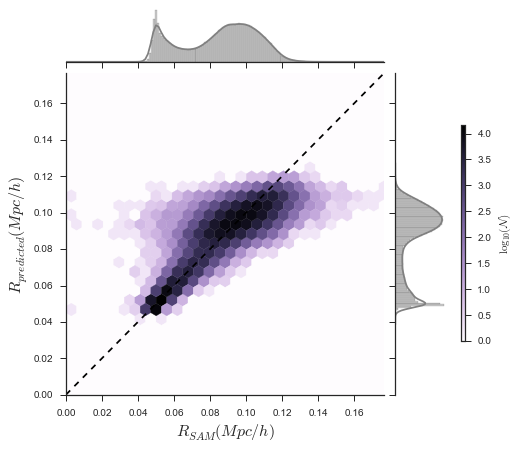

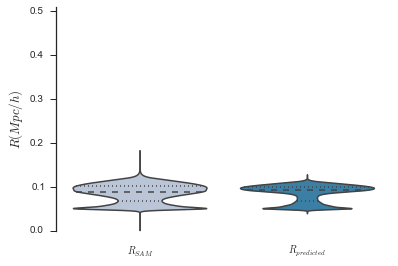

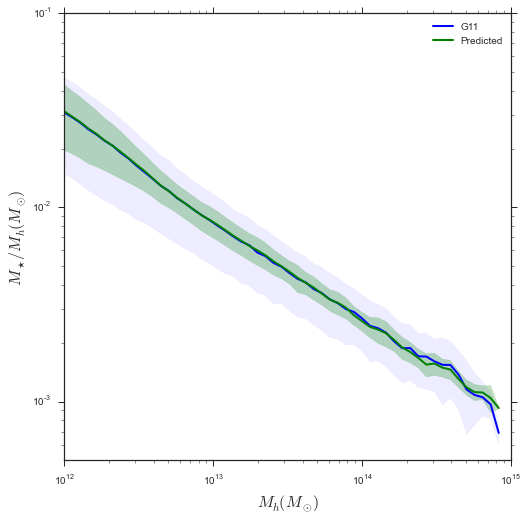

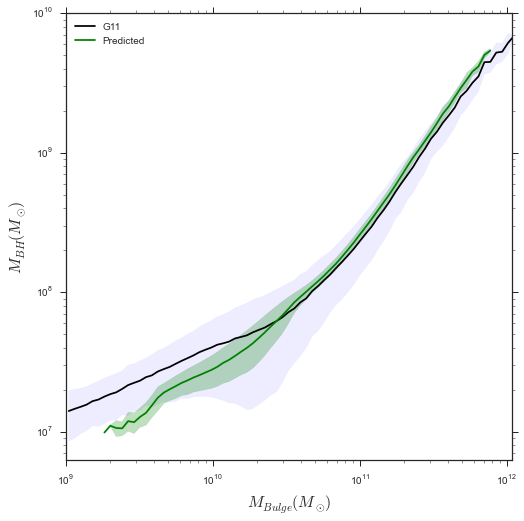

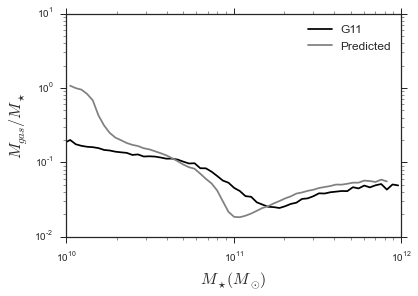

MSE using Extra Trees for predicting the cold gas mass including the baryonic inputs is 0.106448
R^2 score using Extra Trees for predicting the cold gas mass including the baryonic inputs is 0.797985
Pearson correlation using Extra Trees for predicting the cold gas mass including the baryonic inputs is 0.898251


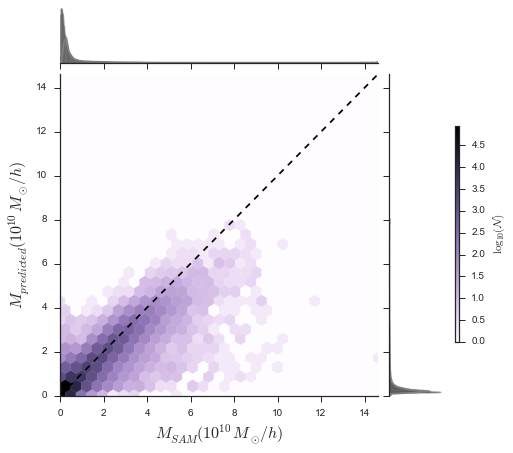

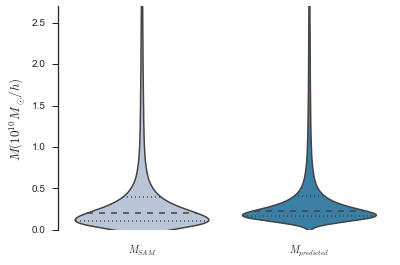

In [30]:
'''
param_dist = {"n_estimators":[43,46,50],
              "max_depth":[10,12,14]
              }
etree = ExtraTreesRegressor()
grid_search = GridSearchCV(etree, param_grid=param_dist)
grid_search.fit(B_train, M_train)

report(grid_search.grid_scores_)
'''
etree = ExtraTreesRegressor(n_estimators=700, min_samples_split=5, n_jobs=-1)
etree.fit(H_train, M_train)
M_pred_etree = etree.predict(H_test)

mse_etree = mse(M_test, M_pred_etree)
del etree

print('MSE using Extra Trees for predicting the stellar mass is %f, cold gas mass is %f, bulge mass is %f, hot gas mass is %f, cooling radius is %f and black hole mass is %f\n' % (mse_etree[0], mse_etree[1], mse_etree[2], mse_etree[3], mse_etree[4], mse_etree[5]))

factors = base_mse/mse_etree

print('Factor reduction (MSE_b/MSE) for Extra Trees for predicting the stellar mass is %f, cold gas mass is %f, bulge mass is %f, hot gas mass is %f, cooling radius is %f and black hole mass is %f\n' % (factors[0], factors[1],  factors[2], factors[3], factors[4], factors[5])) #TODO: prettier way to print this stuff
print('R^2 score using Extra Trees for predicting the stellar mass is %f, cold gas mass is %f, bulge mass is %f, hot gas mass is %f, cooling radius is %f and black hole mass is %f\n' % (r2_score(M_test[:,0], M_pred_etree[:,0]), r2_score(M_test[:,1], M_pred_etree[:,1]),  r2_score(M_test[:,2], M_pred_etree[:,2]), r2_score(M_test[:,3], M_pred_etree[:,3]), r2_score(M_test[:,4], M_pred_etree[:,4]), r2_score(M_test[:,5], M_pred_etree[:,5])))
print('Pearson correlation using Extra Trees for predicting the stellar mass is %f, cold gas mass is %f, bulge mass is %f, hot gas mass is %f, cooling radius is %f and black hole mass is %f' % (pearsonr(M_test[:,0], M_pred_etree[:,0])[0], pearsonr(M_test[:,1], M_pred_etree[:,1])[0],  pearsonr(M_test[:,2], M_pred_etree[:,2])[0], pearsonr(M_test[:,3], M_pred_etree[:,3])[0], pearsonr(M_test[:,4], M_pred_etree[:,4])[0], pearsonr(M_test[:,5], M_pred_etree[:,5])[0]))

[genplots_M(np.c_[M_test[:,i], M_pred_etree[:,i]], mse_etree[i]) for i in [x for x in xrange(0,6) if x != 4]]
genplots_M(np.c_[M_test[:,4], M_pred_etree[:,4]], mse_etree[4], plot_type='R') 

plot_smhm(M_test[:,0], M_pred_etree[:,0], H_test[:,0])
plot_bhbulge(M_test[:,5], M_pred_etree[:,5], M_test[:,2], M_pred_etree[:,2])
plot_coldgasfrac(M_test[:,1], M_pred_etree[:,1], M_test[:,0], M_pred_etree[:,0])

C_train = np.ravel(C_train)
C_test = np.ravel(C_test)

etree = ExtraTreesRegressor(n_estimators=700, n_jobs=-1, min_samples_split=5)
etree.fit(N_train, C_train)
C_pred_etree = etree.predict(N_test)

mse_etree_mod = mse(C_test,C_pred_etree)

print('MSE using Extra Trees for predicting the cold gas mass including the baryonic inputs is %f' % mse_etree_mod)
print('R^2 score using Extra Trees for predicting the cold gas mass including the baryonic inputs is %f' %  r2_score(C_test[:], C_pred_etree[:]))
print('Pearson correlation using Extra Trees for predicting the cold gas mass including the baryonic inputs is %f' % pearsonr(C_test[:], C_pred_etree[:])[0])

genplots_M(np.c_[C_test[:],C_pred_rf[:]], mse_rf_mod)

Welp. This is great. Using G11 to train the machine learning algorithms, the total stellar mass, stellar mass in the bulge, cold gas mass and hot gas mass in the Millennium simulation are predicted fairly robustly. ML provides a powerful framework to explore the problem of galaxy formation in part due to its relative simplicity, computational efficiency and its ability to model complex physical relationships. 